<a href="https://colab.research.google.com/github/greyson-newton/youtube_ai/blob/master/partisanNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls
import os
os.chdir("drive/My Drive/projects-deep_learning/Partisan-NLP")

drive  sample_data


In [ ]:
!ls

classify_headlines.py	  fastText		    soups
clustered_data		  nlp_graphs		    v2_classify_headlines.py
collect-data.py		  partisanNLP.ipynb	    v2_collect-data.py
collect-training_data.py  python_history_11_20.txt  v2-collect_training_data.py
data			  read_data.py		    v3_classify_headlines.py
done.mp3		  requests


In [ ]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from scipy.stats import loguniform

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
#Import packages

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

import pandas as pd

import gensim
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from textblob import TextBlob


import xgboost, numpy, textblob, string
from tensorflow import keras 
import numpy as np

import os,re
import pickle
import warnings
warnings.filterwarnings("ignore")
!export PYTHONWARNINGS="ignore"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Main

In [ ]:
def main(models,acc,parameters,predictions,title=False,binary=False):
	params=[title,binary]
	testDF,trainDF= pd.DataFrame(),pd.DataFrame()

	param_text=''
	if title:
		param_text='title text'
	if not(title):
		param_text='desc. text' 
	if binary:
		param_text+=' binary labels'
	if not(binary):
		param_text+=' 1-5 labels'
	trainDF=import_data(trainDF,title,binary)
	train_x, valid_x, train_y, valid_y    = preprocess_data(trainDF)
    
	encoder = preprocessing.LabelEncoder()
	train_y = encoder.fit_transform(train_y)
	valid_y = encoder.fit_transform(valid_y)
    
	xtrain_count,xvalid_count             = mk_count_vectors(trainDF,train_x, valid_x)
	xtrain_word_tfidf,xvalid_word_tfidf   = mk_word_TFIDF_vectors(trainDF,train_x, valid_x)
	xtrain_ngram_tfidf,xvalid_ngram_tfidf = mk_ngram_TFIDF_vectors(trainDF,train_x, valid_x)
	xtrain_chars_tfidf,xvalid_chars_tfidf = mk_char_TFIDF_vectors(trainDF,train_x, valid_x)
    
	log_reg_model=linear_model.LogisticRegression()
	linear_dict={}
	def linear_classifier():
		print("(LR) Logistic Regression Model:")
        # Linear Classifier on Count Vectors
		cnt_preds,cnt_accuracy = train_model(log_reg_model, xtrain_count, train_y, xvalid_count,valid_y)
		print ("\tLR, Count Vectors: ", cnt_accuracy) 
# 		acc.append(accuracy)    
        # Linear Classifier on Word Level TF IDF Vectors
		wrd_preds,wrd_accuracy = train_model(log_reg_model, xtrain_word_tfidf, train_y,xvalid_word_tfidf,valid_y)
		print ("\tLR, WordLevel TF-IDF: ", wrd_accuracy) 
# 		acc.append(accuracy)  
        # Linear Classifier on Ngram Level TF IDF Vectors
		ng_preds,ng_accuracy = train_model(log_reg_model, xtrain_ngram_tfidf, train_y, xvalid_ngram_tfidf, valid_y)
		print ("\tLR, N-Gram Vectors: ", ng_accuracy)
# 		acc.append(accuracy)  
        # Linear Classifier on Character Level TF IDF Vectors
		ch_preds,ch_accuracy = train_model(log_reg_model, xtrain_chars_tfidf, train_y, xvalid_chars_tfidf,valid_y)
		print ("\tLR, CharLevel Vectors: ", ch_accuracy)
        
		log_dict = {"count":cnt_accuracy , "word":wrd_accuracy ,"char":ch_accuracy , "ngram":ng_accuracy}          
		log_pred_dict = {"count":cnt_preds , "word":wrd_preds ,"char":ch_preds , "ngram":ng_preds}
        
		parameters.append(param_text)
		models.append('Log. Classification')
		acc.append(log_dict)
		predictions.append(log_pred_dict)
        
	RF_model=ensemble.RandomForestClassifier()
	def rf_classifer():
		print("(RF) Random Forest 'Bagging' Model:")
		# RF on Count Vectors
		cnt_preds,cnt_accuracy = train_model(RF_model, xtrain_count, train_y, xvalid_count,valid_y)
		print ("\tRF, Count Vectors: ", cnt_accuracy)
# 		acc.append(accuracy)    
		# RF on Word Level TF IDF Vectors
		wrd_preds,wrd_accuracy = train_model(RF_model, xtrain_word_tfidf, train_y, xvalid_word_tfidf,valid_y)
		print ("\tRF, WordLevel TF-IDF: ", wrd_accuracy)
        
		rForest_dict = {"count":cnt_accuracy , "word":wrd_accuracy}
		rForest_pred_dict = {"count":cnt_preds , "word":wrd_preds}
        
		parameters.append(param_text)        
		acc.append(rForest_dict)
		predictions.append(rForest_pred_dict)        
		models.append('Random Forest Classification')
  



    #SKLEARN MODELS#  

    #XGB hyperparameter RANDOM grid search    
	skf = StratifiedKFold(n_splits=2, shuffle = True, random_state = 1001) 
	if binary:
		xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', silent=True, nthread=1,use_label_encoder=False,eval_metric='logloss')
		n_classes=2
	if not(binary):
		xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='multi:softprob', silent=True, nthread=1,use_label_encoder=False)
		n_classes=5        
	params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]}
	def XGBoost():
		print("(XGB) XGBoost 'Extreme Gradient' Model:")        
		# Extereme Gradient Boosting on Count Vectors
		random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=n_classes, scoring='roc_auc', n_jobs=4, cv=skf.split(xtrain_count,train_y), verbose=3, random_state=1001 )        
		cnt_preds,cnt_accuracy = train_model(grid_search, xtrain_count, train_y, xvalid_count,valid_y,True)
		print ("XGB, Count Vectors: ", cnt_accuracy)
# 		Extereme Gradient Boosting on Word Level TF IDF Vectors
		random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=2, scoring='roc_auc', n_jobs=4, cv=skf.split(xtrain_word_tfidf,train_y), verbose=3, random_state=1001 )
		wrd_preds,wrd_accuracy = train_model(random_search, xtrain_word_tfidf, train_y, xtrain_word_tfidf,valid_y,True)
		print ("XGB, WordLevel TF-IDF: ", wrd_accuracy)
		# Extereme Gradient Boosting on Character Level TF IDF Vectors
# 		ch_preds,ch_accuracy = train_model(random_search, xtrain_chars_tfidf, train_y, xtrain_chars_tfidf,valid_y,True)
# 		print ("XGB, CharLevel Vectors: ", ch_accuracy)
        
		xgb_acc_dict = {"word":wrd_accuracy,"count":cnt_accuracy}
		xgb_pred_dict = {"word":wrd_preds,"count":cnt_preds}
        
		parameters.append(param_text)        
		acc.append(xgb_acc_dict)
		predictions.append(xgb_pred_dict)        
		models.append('XGBoost Classification')
    
    #RC Hyperparameter RANDOM grid search
	RC_model = RidgeClassifier()        
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	alphas = np.array([.1,1, 250, 300, 500,1000])  
	grid_search = GridSearchCV(estimator=RC_model, param_grid=dict(alpha=alphas), n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

	def ridge_classifier():
		print("(RC) Ridge Classification Model:") 
		cnt_preds,cnt_acc=train_model(grid_search,xtrain_count,train_y,xvalid_count,valid_y,True)
		print("\tRC, Count Vectors: ",cnt_acc)
		ch_preds,ch_acc=train_model(grid_search,xtrain_chars_tfidf,train_y,xtrain_chars_tfidf,valid_y,True)
		print("\tRC, CharLevel TF-IDF: ",ch_acc)        
		wrd_preds,wrd_acc=train_model(grid_search,xtrain_word_tfidf,train_y,xtrain_word_tfidf,valid_y,True)
		print("\tRC, WordLevel TF-IDF: ",wrd_acc)
        
		ridge_acc_dict = {"count":cnt_acc , "word":wrd_acc, "char":ch_acc}
		ridge_pred_dict = {"count":cnt_preds , "word":wrd_preds, "char":ch_preds}
        
		parameters.append(param_text)        
		acc.append(ridge_acc_dict)
		predictions.append(ridge_pred_dict)        
		models.append('Ridge Classification') 
        
	RFB_model = BaggingClassifier() 
	n_estimators = [10, 100, 1000]
	# define grid search
	grid = dict(n_estimators=n_estimators)
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	grid_search = GridSearchCV(estimator=RFB_model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
    
	def rfBag_classifier():
		print("(RF-B) rfBagging Model:") 

		cnt_preds,cnt_acc=train_model(grid_search,xtrain_count,train_y,xvalid_count,valid_y,True)
		print("\tRFB, Count Vectors: ",cnt_acc)
		ch_preds,ch_acc=train_model(grid_search,xtrain_chars_tfidf,train_y,xtrain_chars_tfidf,valid_y,True)
		print("\tRFB, WordLevel TF-IDF: ",ch_acc)        
		wrd_preds,wrd_acc=train_model(grid_search,xtrain_word_tfidf,train_y,xtrain_word_tfidf,valid_y,True)
		print("\tRFB, CharLevel TF-IDF: ",wrd_acc)
        
		rfBag_acc_dict = {"count":cnt_acc , "word":wrd_acc, "char":ch_acc}
		rfBag_pred_dict = {"count":cnt_preds , "word":wrd_preds, "char":ch_preds}
        
		parameters.append(param_text)        
		acc.append(rfBag_acc_dict)
		predictions.append(rfBag_pred_dict)        
		models.append("Random Forest 'Bagging'")        
        
	from sklearn.linear_model import LogisticRegressionCV      
	searchCV = LogisticRegressionCV(
    Cs=list(np.power(10.0, np.arange(-10, 10)))
    ,penalty='l2'
    ,scoring='roc_auc'
    ,cv=5
    ,random_state=777
    ,max_iter=10000
    ,fit_intercept=True
    ,solver='newton-cg'
    ,tol=10
)
	log_reg_sklerdel=linear_model.LogisticRegression()
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# define search space
	space = dict()
	space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
	space['penalty'] = ['l1', 'l2', 'elasticnet']
	space['C'] = loguniform(1e-5, 100)
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	grid_search = RandomizedSearchCV(log_reg_sklerdel, space, n_iter=10, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)

    
	def linear_sklearn_classifier():
		print("(LR-s) Logistic Regression sklearn Model:")
        # Linear Classifier on Count Vectors
		cnt_preds,cnt_accuracy = train_model(searchCV, xtrain_count, train_y, xvalid_count,valid_y,True)
		print ("\tLR-s, Count Vectors: ", cnt_accuracy) 
# 		acc.append(accuracy)    
        # Linear Classifier on Word Level TF IDF Vectors
		wrd_preds,wrd_accuracy = train_model(searchCV, xtrain_word_tfidf, train_y,xvalid_word_tfidf,valid_y,True)
		print ("\tLR-s, WordLevel TF-IDF: ", wrd_accuracy) 
# 		acc.append(accuracy)  
        # Linear Classifier on Ngram Level TF IDF Vectors
		ng_preds,ng_accuracy = train_model(searchCV, xtrain_ngram_tfidf, train_y, xvalid_ngram_tfidf, valid_y,True)
		print ("\tLR-s, N-Gram Vectors: ", ng_accuracy)
# 		acc.append(accuracy)  
        # Linear Classifier on Character Level TF IDF Vectors
		ch_preds,ch_accuracy = train_model(searchCV, xtrain_chars_tfidf, train_y, xvalid_chars_tfidf,valid_y,True)
		print ("\tLR-s, CharLevel Vectors: ", ch_accuracy)
        
		log_skl_acc_dict = {"count":cnt_accuracy , "word":wrd_accuracy ,"char":ch_accuracy , "ngram":ng_accuracy}          
		log_skl_pred_dict = {"count":cnt_preds , "word":wrd_preds ,"char":ch_preds , "ngram":ng_preds}
        
		parameters.append(param_text)
		models.append('Ensemble Log. Classification')
		acc.append(log_skl_acc_dict)
		predictions.append(log_skl_pred_dict)
                
        
	if title:
		text_string='using article titles'
	else:
		text_string='using article descriptions'
	if binary:
		data_string='and binary (partisan-non_partisan) labels:\n'
	if not(binary):
		data_string='and multi-class (1-5:{Left-Right}) labels:\n'
	print('Model Selection Report',text_string,data_string)    

	linear_classifier()  
# 	linear_sklearn_classifier()
# 	rf_classifer()  
# 	XGBoost()          
# 	ridge_classifier()    
	rfBag_classifier()    
    

In [ ]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, valid_y, is_sklearn=False, is_neural_net=False):
    if is_sklearn:
#         print('is sklearn classifer')
        grid_result=classifier.fit(feature_vector_train, label)
#         print('sklearn fitted')
        # summarize results
#         print("\tBest: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']
#         for mean, stdev, param in zip(means, stds, params):
#             print("%f (%f) with: %r" % (mean, stdev, param)) 
#         print('about to predict')
        preds = grid_result.predict(feature_vector_valid)
        return preds,round(grid_result.best_score_,3)
    print(feature_vector_train[0])
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    # predict the labels on validation dataset
    preds = classifier.predict(feature_vector_valid)
   
    accu=metrics.accuracy_score(preds, valid_y)
    return preds,round(accu,3)

# Data Processing

In [ ]:
def import_data(df,title,binary,categorical_label,sentiment=False,pathname='./data/breaking_news.csv'):

	data = pd.read_csv(pathname)
	print(data)    
	data = data.dropna() 


    
	if title:
		text=data['title'].tolist()
	if not(title):
		text=data['desc.'].tolist()
	if sentiment==False:
		if binary:
			if categorical_label:
				data.loc[data['bias'] == 'Center', 'bias'] = 'non-partisan'
				data.loc[data['bias'] != 'non-partisan', 'bias'] = 'partisan'
				labels=data['bias'].tolist()				
			if not(categorical_label):
				data.loc[data['bias_id'] == 3, 'bias_id'] = 0
				data.loc[data['bias_id'] != 0, 'bias_id'] = 1
				labels=data['bias_id'].tolist()   
		if not(binary):
			if categorical_label:
				data.loc[data['bias'] == 'moderate', 'bias'] = 'Center'
				data.loc[data['bias'] == ' Lean Left', 'bias'] = 'Lean Left'
				data.loc[data['bias'] == ' Lean Right', 'bias'] = 'Lean Right'	
				data.loc[data['bias'] == ' Left', 'bias'] = 'Left'	
				data.loc[data['bias'] == ' Right', 'bias'] = 'Right'																																		
				labels=data['bias'].tolist()	
			if not(categorical_label):
				labels=data['bias_id'].tolist()

	# polarization = data['polarity'].tolist()
	# subjection = data['subjectivity'].tolist() 
 
	df['text'] = text
	df['label'] = labels
	# df['polarity'] = polarization
	# df['subjectivity'] = subjection     
	return df



In [ ]:
def print_plot(df,index):
    example = df[df.index == index][['text', 'label']].values[0]
    plt.figure(figsize=(10,4))
    df.label.value_counts().plot(kind='bar');
#     if len(example) > 0:
#         print(example[0])
#         print('Tag:', example[1])

def preprocess_data(df):
    # cleans text     
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    newline= re.compile('\n')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))
    def clean_text(text):
        text = text.lower() # lowercase text
        text = newline.sub('  ',text)
        text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
        text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
        text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
        return text
    
    # cleaned text     
    df['text'] = df['text'].apply(clean_text) 
    text=df['text'].tolist()
    
    print(df.columns)
    # polarization = df['polarity'].tolist()
    # subjection = df['subjectivity'].tolist()    
    # temp=[]
    # for t,p,s in zip(text,polarization,subjection):
    #     temp.append(t+' '+str(p)+' '+str(s))
    # df['text'] = temp
    # print(df['text'])
    # split the dataset into training and validation datasets 
    train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df['text'], df['label'])

    # label encode the target variable 
    encoder = preprocessing.LabelEncoder()
    train_y = encoder.fit_transform(train_y)
    valid_y = encoder.fit_transform(valid_y)
#     print(type(train_x),type(valid_x),type(train_y),type(valid_y))
#     print('--Data Preview')
#     print_plot(df,10)
    return train_x, valid_x, train_y, valid_y

In [ ]:
# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    pos_family = {
	    'noun' : ['NN','NNS','NNP','NNPS'],
	    'pron' : ['PRP','PRP$','WP','WP$'],
	    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
	    'adj' :  ['JJ','JJR','JJS'],
	    'adv' : ['RB','RBR','RBS','WRB']
    }
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

def feature_engineering(df):
	df['char_count'] = df['text'].apply(len)
	df['word_count'] = df['text'].apply(lambda x: len(x.split()))
	df['word_density'] = df['char_count'] / (df['word_count']+1)
	df['punctuation_count'] = df['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
	df['title_word_count'] = df['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
	df['upper_case_word_count'] = df['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))	
	df['noun_count'] = df['text'].apply(lambda x: check_pos_tag(x, 'noun'))
	df['verb_count'] = df['text'].apply(lambda x: check_pos_tag(x, 'verb'))
	df['adj_count'] = df['text'].apply(lambda x: check_pos_tag(x, 'adj'))
	df['adv_count'] = df['text'].apply(lambda x: check_pos_tag(x, 'adv'))
	df['pron_count'] = df['text'].apply(lambda x: check_pos_tag(x, 'pron'))



In [ ]:
def mk_count_vectors(df,train_x,valid_x):
	# create a count vectorizer object 
	count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
	count_vect.fit(df['text'])
	# transform the training and validation data using count vectorizer object
	xtrain_count =  count_vect.transform(train_x)
	xvalid_count =  count_vect.transform(valid_x)
	return xtrain_count,xvalid_count
def mk_word_TFIDF_vectors(df,train_x,valid_x): # word level tf-idf
	tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
	tfidf_vect.fit(df['text'])
	xtrain_word_tfidf =  tfidf_vect.transform(train_x)
	xvalid_word_tfidf =  tfidf_vect.transform(valid_x)
	return 	xtrain_word_tfidf,xvalid_word_tfidf
def mk_ngram_TFIDF_vectors(df,train_x,valid_x): # ngram level tf-idf
	tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
	tfidf_vect_ngram.fit(df['text'])
	xtrain_ngram_tfidf =  tfidf_vect_ngram.transform(train_x)
	xvalid_ngram_tfidf =  tfidf_vect_ngram.transform(valid_x)
	return xtrain_ngram_tfidf,xvalid_ngram_tfidf
def mk_char_TFIDF_vectors(df,train_x,valid_x): # characters level tf-idf
	tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
	tfidf_vect_ngram_chars.fit(df['text'])
	xtrain_chars_tfidf =  tfidf_vect_ngram_chars.transform(train_x) 
	xvalid_chars_tfidf =  tfidf_vect_ngram_chars.transform(valid_x) 
	return xtrain_chars_tfidf,xvalid_chars_tfidf

In [ ]:
def save_models(models,accs,predictions,params):
	pathname='./data/models/'
	modelDF=pd.DataFrame()
	filenames=[]

	for model in models:
		if os.path.isdir(pathname):
			filename = pathname+str(model)+'.sav'
			pickle.dump(model, open(filename, 'wb'))
			filenames.append(filename)
			print('saved ',model,' asa pickle')

		else:
			os.makedirs(pathname)
			print("created folder : ", pathname)			
			filename = pathname+str(model)+'.sav'
			pickle.dump(model, open(filename, 'wb'))
			filenames.append(filename)
			print('saved ',model,' asa pickle')

	modelDF['models']=models
	modelDF['parameters']=params        
	modelDF['accuracies']=accs
	modelDF['predictions']=predictions
	modelDF['filenames']=filenames
	return modelDF

# Run Program

In [ ]:
# sentiment analysis -> sentence to list of variables that describe sentiment
# Attention models 

models=[]
acc=[]
parameters=[]
hyperparameters=[]
predictions=[]
# title,binary=False,False
# main(models,acc,parameters,title,binary)

title,binary=False,True
main(models,acc,parameters,predictions,title,binary)

# title,binary=False,True
# main(models,acc,parameters,predictions,title,binary)

title,binary=False,False
main(models,acc,parameters,predictions,title,binary)

modelReportDF=save_models(models,acc,predictions,parameters)

                     topic  ...                                              desc.
0      Abortion- Lean Left  ...  President Biden’s far-reaching assertion of pr...
1     Abortion- Lean Right  ...  If you want to carry a firearm in New York sta...
2      Abortion - moderate  ...  A key check on presidential power doesn’t seem...
3      Abortion- Lean Left  ...  On June 1, 2021, New York Times reporter Maggi...
4     Abortion- Lean Right  ...  We can thank judges who were prepared to enfor...
...                    ...  ...                                                ...
2020     World- Lean Right  ...  After his home was bombed in 1956, Martin Luth...
2021      World - moderate  ...  “The Supreme Court on Wednesday seemed ready t...
2022           World- Left  ...  The biggest surprise in Wednesday morning’s ar...
2023          World- Right  ...  A Missouri official has asked the state Suprem...
2024      World - moderate  ...  Anew lawsuit alleges the National Rifle Associ...

[20

KeyError: ignored

# Experimental


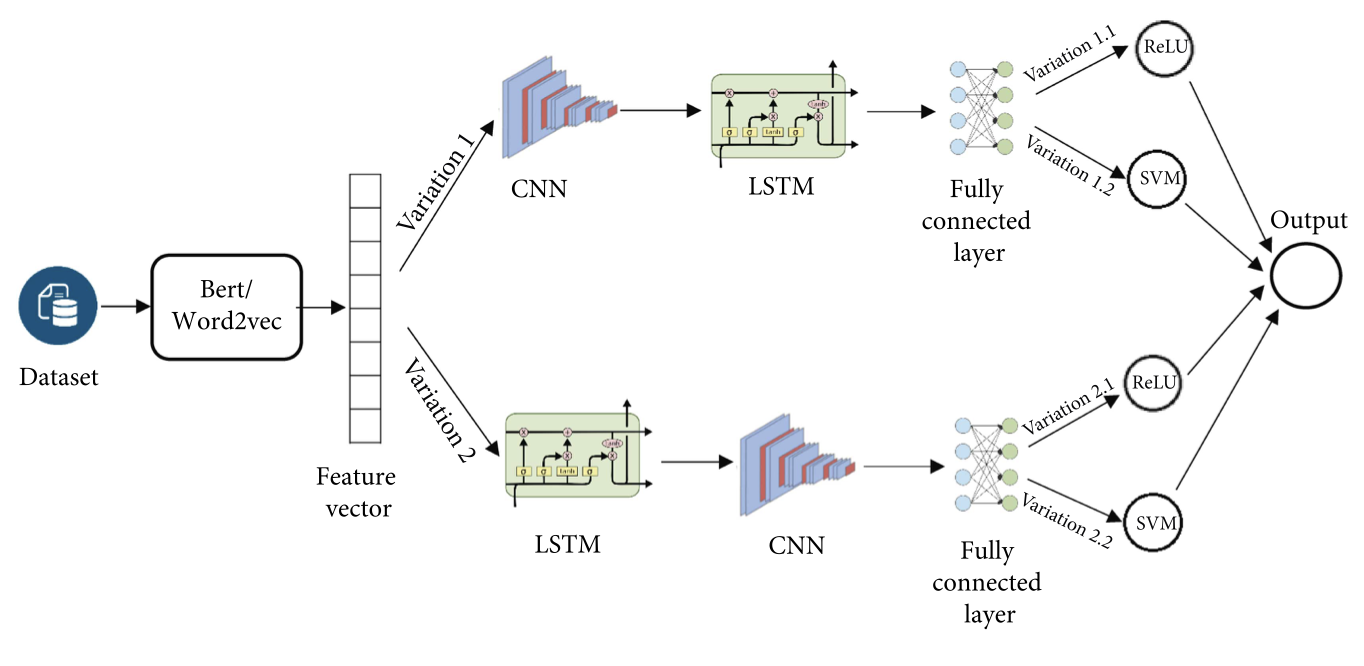

In [ ]:
from IPython.display import Image
Image('./figs/sentiment_feature_engineering.png')

1. Data->Clean->Word2vec/BERT->CNN->LSTM->Relu

2. Data->Clean->Word2vec/BERT->LSTM->CNN->Relu

3. Data->Clean->Word2vec/BERT->CNN->LSTM->SVM

4. Data->Clean->Word2vec/BERT->LSTM->CNN->SVM

In [ ]:
# DATA

sentDF=pd.DataFrame()
title,binary=True,False
sentDF=import_data(sentDF,title,binary)
sentDF


In [ ]:
# DATA->CLEAN
from gensim.models import Word2Vec

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
newline= re.compile('\n')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def clean_text(text):
    text = text.lower() # lowercase text
    text = newline.sub('  ',text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

# cleaned text     
sentDF['text'] = sentDF['text'].apply(clean_text)


In [ ]:
# Data->Clean->Word2Vec
from gensim.models import Word2Vec

# custom w2v vectors
article_titles=sentDF['text'].tolist() 
model = Word2Vec(sentences=article_titles, window=5, min_count=1, workers=4)
model.save("word2vec.model")

# glove w2v pretrained vectors
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))
glove_vectors = gensim.downloader.load('glove-twitter-25')

In [ ]:
!pip install transformers

In [ ]:
# Data->Clean->BERT (usisng article bodies not titles)

# DATA
sentDF=pd.DataFrame()
title,binary,categorical_label=False,False,True
sentDF=import_data(sentDF,title,binary,categorical_label)
# print(sentDF)

# CLEAN
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
newline= re.compile('\n')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def clean_text(text):
    text = text.lower() # lowercase text
    text = newline.sub('  ',text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

# cleaned text     
sentDF['text'] = sentDF['text'].apply(clean_text)



# #  BERT Preprocessing
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertForPreTraining.from_pretrained('bert-base-uncased')


from __future__ import absolute_import, division, print_function, unicode_literals
import os, datetime

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# splitting data
X_train, X_test = train_test_split(sentDF,test_size=0.2,random_state=111)

sentDF['label'].value_counts() 

                     topic  ...                                              desc.
0      Abortion- Lean Left  ...  President Biden’s far-reaching assertion of pr...
1     Abortion- Lean Right  ...  If you want to carry a firearm in New York sta...
2      Abortion - moderate  ...  A key check on presidential power doesn’t seem...
3      Abortion- Lean Left  ...  On June 1, 2021, New York Times reporter Maggi...
4     Abortion- Lean Right  ...  We can thank judges who were prepared to enfor...
...                    ...  ...                                                ...
2020     World- Lean Right  ...  After his home was bombed in 1956, Martin Luth...
2021      World - moderate  ...  “The Supreme Court on Wednesday seemed ready t...
2022           World- Left  ...  The biggest surprise in Wednesday morning’s ar...
2023          World- Right  ...  A Missouri official has asked the state Suprem...
2024      World - moderate  ...  Anew lawsuit alleges the National Rifle Associ...

[20

Center        675
Lean Left     440
Lean Right    352
Right         323
Left          235
Name: label, dtype: int64

  sentDF['label'].value_counts() ->
  
  1. Center     675
  2. Left       440
  3. LRight     352
  4. Right      323
  5. LLeft      235

looks like the classes are imbalanced, need to implement class_weight

In [ ]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight(class_weight = 'balanced',
                                                       classes = np.unique(sentDF['label']),
                                                       y = sentDF['label']))
# made class weights
class_weights.sort()
class_weights
# class_weights = class_weights.reshape((5,))
# class weights need to be in a dict
weights={}
for i,weight in enumerate(class_weights):
  weights[i]=weight
weights

{0: 0.6,
 1: 0.9204545454545454,
 2: 1.1505681818181819,
 3: 1.2538699690402477,
 4: 1.7234042553191489}

In [ ]:
dataset_train = tf.data.Dataset.from_tensor_slices((X_train['text'].values,X_train['label'].values))
dataset_test = tf.data.Dataset.from_tensor_slices((X_test['text'].values,X_test['label'].values))
for text,target in dataset_train.take(5):
  print('Article Body {}, target {}'.format(text,target))

In [ ]:
table = tf.lookup.StaticHashTable(
    initializer = tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(['Left','Lean Left','Center','Lean Right','Right']),
        values=tf.constant([0,1,2,3,4]),
    ),
    default_value=tf.constant(-1),
    name="target_encoding"
)

@tf.function
def target(x):
  return table.lookup(x)

In [ ]:
def show_batch(dataset, size=5):
  for batch, label in dataset.take(size):
    print(batch.numpy())
    print(target(label).numpy())

In [ ]:
show_batch(dataset_test,10)

In [ ]:
def fetch(text,labels):
  return text, tf.one_hot(target(labels),5)

In [ ]:
train_data_f=dataset_train.map(fetch)
test_data_f=dataset_test.map(fetch)
train_data, train_labels = next(iter(train_data_f.batch(5)))
train_data, train_labels

In [ ]:
#  pretrained embedding from tensorflow
#  This might be where the magic needs to happen for partisan detection
embedding = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
hub_layer = hub.KerasLayer(embedding, output_shape=[128], input_shape=[],
                           dtype=tf.string, trainable=True)

hub_layer(train_data[:1])

In [ ]:
# BERT -> LSTM

# model = tf.keras.Sequential()
# model.add(hub_layer)
# model.add(tf.keras.layers.Reshape( target_shape=(128 , 1 ) ))
# model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))
# model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)))
# for units in [128, 64 ]:
#   model.add(tf.keras.layers.Dense(units, activation='relu'))
#   model.add(tf.keras.layers.Dropout(0.3))
# model.add(tf.keras.layers.Dense(6, activation='softmax'))

# model.summary()


# BERT -> Sequential
model = tf.keras.Sequential()
model.add(hub_layer)
for units in [128,128,64,32]:
  model.add(tf.keras.layers.Dense(units,activation='relu'))
  model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(5,activation='softmax'))

model.summary()

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
train_data_f=train_data_f.shuffle(7000).batch(200)
test_data_f=test_data_f.batch(200)

history = model.fit(train_data_f,
                    epochs=50,
                    validation_data=test_data_f,
                    verbose=1,
                    class_weight=weights)

Epoch 1/50
9/9 [==============================] - 16s 2s/step - loss: 1.8231 - accuracy: 0.2673 - val_loss: 1.5689 - val_accuracy: 0.3531
Epoch 2/50
9/9 [==============================] - 14s 2s/step - loss: 1.7676 - accuracy: 0.3241 - val_loss: 1.5508 - val_accuracy: 0.3531
Epoch 3/50
9/9 [==============================] - 15s 2s/step - loss: 1.7278 - accuracy: 0.3265 - val_loss: 1.5357 - val_accuracy: 0.3531
Epoch 4/50
9/9 [==============================] - 16s 2s/step - loss: 1.6871 - accuracy: 0.3284 - val_loss: 1.5151 - val_accuracy: 0.3531
Epoch 5/50
9/9 [==============================] - 16s 2s/step - loss: 1.6270 - accuracy: 0.3333 - val_loss: 1.4809 - val_accuracy: 0.3531
Epoch 6/50
9/9 [==============================] - 17s 2s/step - loss: 1.5338 - accuracy: 0.3488 - val_loss: 1.4271 - val_accuracy: 0.3852
Epoch 7/50
9/9 [==============================] - 15s 2s/step - loss: 1.4205 - accuracy: 0.4210 - val_loss: 1.3845 - val_accuracy: 0.4173
Epoch 8/50
9/9 [==================